In [206]:
import pandas as pd
import hashlib
import os
from utils import logger
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


from sklearn.feature_selection import SelectFromModel
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from utils import logger

def lassoSelection(X_train, y_train, n):
	"""
	Lasso feature selection.  Select n features.
	"""
	#lasso feature selection
	#print (X_train)
	clf = LassoCV()
	sfm = SelectFromModel(clf, threshold=0)
	sfm.fit(X_train, y_train)
	X_transform = sfm.transform(X_train)
	n_features = X_transform.shape[1]

	#print(n_features)
	while n_features > n:
		sfm.threshold += 0.01
		X_transform = sfm.transform(X_train)
		n_features = X_transform.shape[1]
	features = [index for index,value in enumerate(sfm.get_support()) if value == True  ]
	logger.info("selected features are {}".format(features))
	return features

In [207]:
def specificity_score(y_true, y_predict):
	'''
	true_negative rate
	'''
	true_negative = len([index for index,pair in enumerate(zip(y_true,y_predict)) if pair[0]==pair[1] and pair[0]==0 ])
	real_negative = len(y_true) - sum(y_true)
	return true_negative / real_negative


In [208]:
def model_fit_predict(X_train,X_test,y_train,y_test):
    np.random.seed(2018)
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import precision_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score

    models = {
        'KNeighborsClassifier': KNeighborsClassifier(),
    }
    tuned_parameters = {
        'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10]},
    }

    scores= {}
    for key in models:
        clf = GridSearchCV(models[key], tuned_parameters[key], scoring=None,  refit=True, cv=2)
        clf.fit(X_train,y_train)
        y_test_predict = clf.predict(X_test)
        precision = precision_score(y_test, y_test_predict, average='micro')
        accuracy = accuracy_score(y_test, y_test_predict)
        f1 = f1_score(y_test, y_test_predict, average='micro')
        recall = recall_score(y_test, y_test_predict, average='micro')
        specificity = specificity_score(y_test, y_test_predict)
        scores[key] = [precision,accuracy,f1,recall,specificity]
        # reture the best model which K hyper-parameter can get the highest performance
        best_model = clf.best_estimator_
    return scores, best_model

In [209]:
def draw(scores):
	'''
	draw scores.
	'''
	import matplotlib.pyplot as plt
	logger.info("scores are {}".format(scores))
	ax = plt.subplot(111)
	precisions = []
	accuracies =[]
	f1_scores = []
	recalls = []
	categories = []
	specificities = []
	N = len(scores)
	ind = np.arange(N)  # set the x locations for the groups
	width = 0.1        # the width of the bars
	for key in scores:
		categories.append(key)
		precisions.append(scores[key][0])
		accuracies.append(scores[key][1])
		f1_scores.append(scores[key][2])
		recalls.append(scores[key][3])
		specificities.append(scores[key][4])

	precision_bar = ax.bar(ind, precisions,width=0.1,color='b',align='center')
	accuracy_bar = ax.bar(ind+1*width, accuracies,width=0.1,color='g',align='center')
	f1_bar = ax.bar(ind+2*width, f1_scores,width=0.1,color='r',align='center')
	recall_bar = ax.bar(ind+3*width, recalls,width=0.1,color='y',align='center')
	specificity_bar = ax.bar(ind+4*width,specificities,width=0.1,color='purple',align='center')

	print(categories)
	ax.set_xticks(np.arange(N))
	ax.set_xticklabels(categories)
	ax.legend((precision_bar[0], accuracy_bar[0],f1_bar[0],recall_bar[0],specificity_bar[0]), ('precision', 'accuracy','f1','sensitivity','specificity'))
	ax.grid()
	plt.show()

In [210]:
data_dir ="/Users/xin/Downloads/EE542/Labs/lab10/data/"
data_file = data_dir + "miRNA_matrix.csv"
df = pd.read_csv(data_file)

In [211]:
df.head()
df = df.dropna()
n_labels = df['label'].value_counts()
print(n_labels)
print(df.shape)

2.0     1104
4.0     1081
22.0    1000
0.0      691
Name: label, dtype: int64
(3876, 1883)


In [212]:
	y_data = df.pop('label').values

	df.pop('file_id')

	columns =df.columns
	#print (columns)
	X_data = df.values

	# split the data to train and test set
	X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

	#standardize the data.
	scaler = StandardScaler()
	scaler.fit(X_train)
	X_train = scaler.transform(X_train)
	X_test = scaler.transform(X_test)
	
	# check the distribution of tumor and normal sampels in traing and test data set.
	#logger.info("Percentage of tumor cases in training set is {}".format(sum(y_train)/len(y_train)))
	#logger.info("Percentage of tumor cases in test set is {}".format(sum(y_test)/len(y_test)))

#	n = 7
#	feaures_columns = lassoSelection(X_train, y_train, n)


/Users/xin/anaconda/envs/py3k/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [213]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
num_features=800
pca = PCA(n_components=num_features, whiten=True)
pca.fit(X_train)
X_train = pd.DataFrame(pca.transform(X_train))
X_test = pd.DataFrame(pca.transform(X_test))
print("PCA reduction")
print("feature numbers: "+str(num_features))
#print("explained_variance_ratio_: \n"+str(pca.explained_variance_ratio_))
#print("explained_variance_ratio_.cumsum: \n"+str(pca.explained_variance_ratio_.cumsum())) 
    
#t-SNE better for higher scatter different classes, but only accept number of features is inferior to 4
print("t-SNE evaluation")
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
#new = tsne.fit_transform(X_train)
#features = pd.DataFrame(new)

PCA reduction
feature numbers: 800
explained_variance_ratio_.cumsum: 
[0.10758068 0.14623727 0.17507563 0.19643368 0.2134912  0.22936297
 0.24199373 0.25173982 0.26126811 0.27001589 0.27850101 0.28660775
 0.29410522 0.30154883 0.30849357 0.31524676 0.32192201 0.32840342
 0.33444177 0.34032085 0.34595511 0.35137228 0.35632701 0.36101151
 0.36524293 0.36936671 0.37334287 0.37706706 0.38072737 0.38417798
 0.38754154 0.39079842 0.39400397 0.3971264  0.40023967 0.40331536
 0.40628956 0.40915805 0.41201747 0.4148206  0.4175999  0.42031404
 0.42299133 0.42558671 0.42809902 0.43058274 0.4330144  0.43541766
 0.43777689 0.4401144  0.44241565 0.44468665 0.44691173 0.44912386
 0.45131458 0.45349178 0.45562646 0.45773638 0.45983465 0.46192197
 0.4639719  0.4660178  0.46806294 0.47007978 0.47208    0.47406286
 0.47603513 0.47798539 0.47992012 0.48182803 0.48371474 0.48559473
 0.48745974 0.48930764 0.49114008 0.4929531  0.49475525 0.49655599
 0.49833986 0.50011127 0.50186729 0.50358998 0.50530669 0.5

In [214]:
#print(features)

[2018-10-22 21:55:29,467 - GDC - INFO] scores are {'KNeighborsClassifier': [0.40928632846087704, 0.40928632846087704, 0.4092863284608771, 0.40928632846087704, -0.0048946295037389535]}


['KNeighborsClassifier']


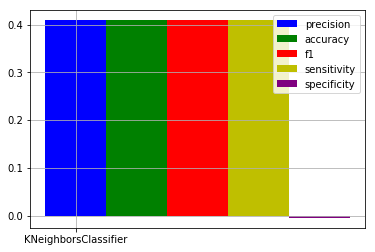

In [215]:
scores, models = model_fit_predict(X_train,X_test,y_train,y_test)
draw(scores)

In [219]:
print(n_labels)
print(n_labels[0])
print(y_test[y_test[:]==2.0])

2.0     1104
4.0     1081
22.0    1000
0.0      691
Name: label, dtype: int64
691
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

In [221]:
y_pred = models.predict_proba(X_test)[:, 1]

In [224]:
print(y_pred), (y_test)

[0.5 0.4 0.5 ... 0.4 0.3 0.2]


(None, array([ 2.,  0.,  4., ..., 22.,  0.,  4.]))

In [220]:
from sklearn.metrics import roc_curve
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt

y_pred = models.predict_proba(X_test)[:, 1]

for i in (2.0,4.0,22.0):
    mask = ((y_test[:] == 0) & (y_test[:] == i))
    arr_test = y_test[mask]
    arr_pred = y_pred[mask]
    print(arr_test)
    print(arr_pred)
    """
    fpr, tpr, _ = roc_curve(arr_test, arr_pred)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='KNN')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve - RF model')
    plt.legend(loc='best')
    plt.show()
    """

[]
[]
[]
[]
[]
[]


In [218]:
from sklearn import metrics
metrics.auc(fpr,tpr)

NameError: name 'fpr' is not defined